# Getting Started with Differential Equations in Julia

## Table of Contents

- [Overview](#overview)
- [Example: Solving Scalar Equations](#scalar_equations)
- [Example: Solving Systems of Equations](#systems_of_equations)
- [Parameterized Functions](#parameterized_functions)
- [Example: Solving Nonhomogeneous Equations](#nonhomogeneous_equations)
- [Example: Using other Types for Systems of Equations](#using_other_types)

## Overview <a id="overview" />

Equations within the realm of this package
include:

  - Discrete equations (function maps, discrete stochastic (Gillespie/Markov)
    simulations)
  - Ordinary differential equations (ODEs)
  - Split and Partitioned ODEs (Symplectic integrators, IMEX Methods)
  - Stochastic ordinary differential equations (SODEs or SDEs)
  - Stochastic differential-algebraic equations (SDAEs)
  - Random differential equations (RODEs or RDEs)
  - Differential algebraic equations (DAEs)
  - Delay differential equations (DDEs)
  - Neutral, retarded, and algebraic delay differential equations (NDDEs, RDDEs, and DDAEs)
  - Stochastic delay differential equations (SDDEs)
  - Experimental support for stochastic neutral, retarded, and algebraic delay differential equations (SNDDEs, SRDDEs, and SDDAEs)
  - Mixed discrete and continuous equations (Hybrid Equations, Jump Diffusions)
  - (Stochastic) partial differential equations ((S)PDEs) (with both finite
    difference and finite element methods)

## Example: Solving Scalar Equations <a id="scalar_equations" />

In this example, we will solve the equation

```math
\frac{du}{dt} = f(u,p,t)
```

on the time interval $t\in[0,1]$, where $f(u,p,t)=αu$. Here, $u$ is the
current state variable, $p$ is our parameter variable (containing things like
a reaction rate or the constant of gravity), and $t$ is the current time.

(In our example, we know by calculus that the solution to this equation is
$u(t)=u₀\exp(αt)$, but we will use DifferentialEquations.jl to solve this
problem *numerically*, which is essential for problems where a symbolic solution
is not known.)

The general workflow is to define a problem, solve the problem, and then analyze
the solution. The full code for solving this problem is:

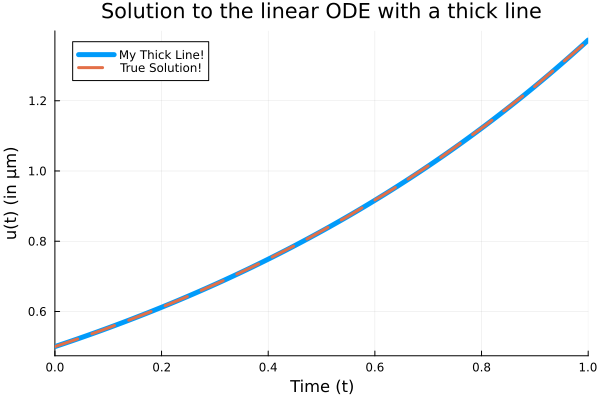

In [2]:
using DifferentialEquations
f(u, p, t) = 1.01 * u
u0 = 1/2
tspan = (0.0, 1.0)
prob = ODEProblem(f, u0, tspan)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)                # Uses 5th order Tsitouras algorithm

using Plots
plot(sol, linewidth = 5, title = "Solution to the linear ODE with a thick line",
    xaxis = "Time (t)", yaxis = "u(t) (in μm)", label = "My Thick Line!")               # legend=false
plot!(sol.t, t -> 0.5 * exp(1.01t), lw = 3, ls = :dash, label = "True Solution!")

### Choosing a Solver Algorithm

DifferentialEquations.jl has a method for choosing the default solver algorithm,
which will find an efficient method to solve your problem. To help users receive
the right algorithm, DifferentialEquations.jl offers a method for choosing
algorithms through hints. This default chooser utilizes the precision of the
number types and the keyword arguments (such as the tolerances) to select an
algorithm. Additionally, one can provide `alg_hints` to help choose good defaults
using properties of the problem and necessary features for the solution.
For example, if we have a stiff problem where we need high accuracy,
but don't know the best stiff algorithm for this problem, we can use:

In [3]:
sol = solve(prob, alg_hints = [:stiff], reltol = 1e-8, abstol = 1e-8);

In DifferentialEquations.jl, some good “go-to” choices for ODEs are:

  - `AutoTsit5(Rosenbrock23())` handles both stiff and non-stiff equations. This
    is a good algorithm to use if you know nothing about the equation.
  - `AutoVern7(Rodas5())` handles both stiff and non-stiff equations in a way that's
    efficient for high accuracy.
  - `Tsit5()` for standard non-stiff. This is the first algorithm to try in
    most cases.
  - `BS3()` for fast low accuracy non-stiff.
  - `Vern7()` for high accuracy non-stiff.
  - `Rodas4()` or `Rodas5()` for small stiff equations with Julia-defined types, events, etc.
  - `KenCarp4()` or `TRBDF2()` for medium-sized (100-2000 ODEs) stiff equations
  - `RadauIIA5()` for really high accuracy stiff equations
  - `QNDF()` for large stiff equations

### Analyzing the Solution

The result of solve is a solution object. We can access the 5th value of the solution with:

In [14]:
sol[5]

0.7892350018733854

But it also serves as a function and we can access any value and it is then interpolated (how dope!):

In [15]:
sol(sol.t[5]+0.001)

0.7900325319101494

### Plotting solutions

While one can directly plot solution time points using the tools given above, convenience commands are defined by recipes for Plots.jl. To plot the solution object, simply call plot:

In [4]:
# plotly()         # You can optionally choose a plotting backend
plot(sol)

# Can obviously also use all the fancy formatiing
plot(sol, linewidth = 5, title = "Solution to the linear ODE with a thick line",
    xaxis = "Time (t)", yaxis = "u(t) (in μm)", label = "My Thick Line!") # legend=false
plot!(sol.t, t -> 0.5 * exp(1.01t), lw = 3, ls = :dash, label = "True Solution!")

## Example 2: Solving Systems of Equations <a id="systems_of_equations" />

In this example, we will solve the Lorenz equations:

```math
\begin{aligned}
\frac{dx}{dt} &= σ(y-x) \\
\frac{dy}{dt} &= x(ρ-z) - y \\
\frac{dz}{dt} &= xy - βz \\
\end{aligned}
```

Defining your ODE function to be in-place updating can have performance benefits.
What this means is that, instead of writing a function which outputs its solution,
you write a function which updates a vector that is designated to hold the solution.
By doing this, DifferentialEquations.jl's solver packages are able to reduce the
amount of array allocations and achieve better performance.

The way we do this is we simply write the output to the 1st input of the function.
For example, our Lorenz equation problem would be defined by the function:

In [5]:
function lorenz!(du, u, p, t)
    du[1] = 10.0 * (u[2] - u[1])
    du[2] = u[1] * (28.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - (8 / 3) * u[3]
end

lorenz! (generic function with 1 method)

and then we can use this function in a problem:

In [6]:
u0 = [1.0; 0.0; 0.0]
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz!, u0, tspan)
sol = solve(prob);

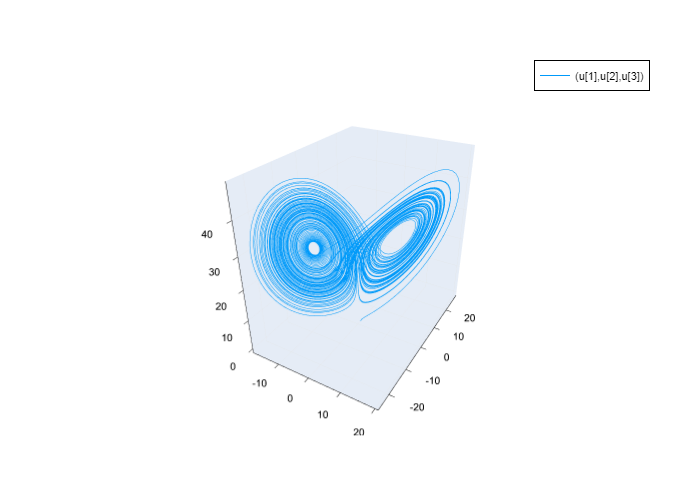

In [7]:
plotlyjs()                      # set the backend to Plotly
plot(sol, idxs = (1, 2, 3))

Note that the default plot for multidimensional systems is an overlay of each timeseries. We can plot the timeseries of just the second component using the variable choices interface once more:

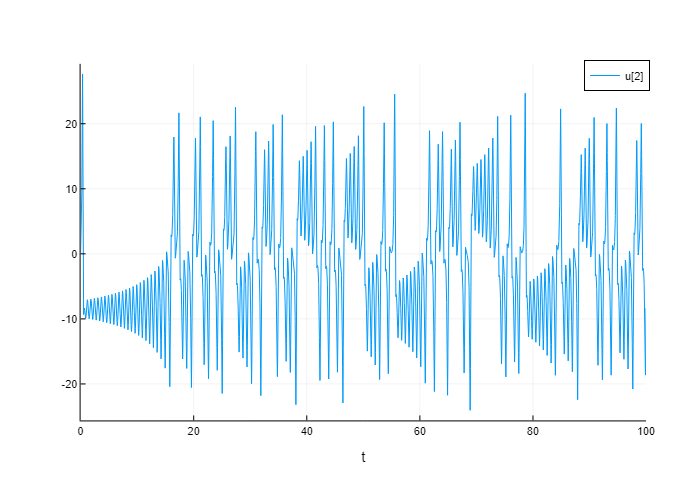

In [8]:
plot(sol, idxs = (0, 2))

> Note that here “variable 0” corresponds to the independent variable (“time”).

## Parameterized Functions <a id="parameterized_functions" />

Often, you want to explicitly have parameters associated with your
differential equations. This can be used by things like
[parameter estimation routines](https://docs.sciml.ai/Overview/stable/highlevels/inverse_problems/).
In this case, you use the `p` values via the syntax:

In [9]:
function parameterized_lorenz!(du, u, p, t)
    du[1] = p[1] * (u[2] - u[1])
    du[2] = u[1] * (p[2] - u[3]) - u[2]
    du[3] = u[1] * u[2] - p[3] * u[3]
end

parameterized_lorenz! (generic function with 1 method)

and then we add the parameters to the `ODEProblem`:

In [10]:
u0 = [1.0, 0.0, 0.0]
tspan = (0.0, 1.0)
p = [10.0, 28.0, 8 / 3]
prob = ODEProblem(parameterized_lorenz!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: 3-element Vector{Float64}:
 1.0
 0.0
 0.0

We can make our functions look nicer by doing a few tricks. For example:

In [11]:
function parameterized_lorenz!(du, u, p, t)
    x, y, z = u
    σ, ρ, β = p
    du[1] = dx = σ * (y - x)
    du[2] = dy = x * (ρ - z) - y
    du[3] = dz = x * y - β * z
end

parameterized_lorenz! (generic function with 1 method)

> Note that the type for the parameters `p` can be anything: you can use arrays, static arrays, named tuples, etc. to enclose your parameters in a way that is sensible for your problem.

Since the parameters exist within the function, functions defined in this manner
can also be used for sensitivity analysis, parameter estimation routines,
and bifurcation plotting. This makes DifferentialEquations.jl a full-stop solution
for differential equation analysis which also achieves high performance.


## Example 3: Solving Nonhomogeneous Equations <a id="nonhomogeneous_equations" />

Parameterized functions can also be used for building **nonhomogeneous ordinary differential equations** (these are also referred to as ODEs with **nonzero right-hand sides**). They are frequently used as models for dynamical systems with external (in general time-varying) **inputs**. As an example, consider a [model of a pendulum](https://en.wikipedia.org/wiki/Pendulum_(mathematics)) consisting of a slender rod of length `l` and mass `m`:

```math
\begin{aligned}
\frac{\mathrm{d}\theta(t)}{\mathrm{d}t} &= \omega(t)\\
\frac{\mathrm{d}\omega(t)}{\mathrm{d}t} &= - \frac{3}{2}\frac{g}{l}\sin\theta(t) + \frac{3}{ml^2}M(t)
\end{aligned},
```

where `θ` and `ω` are the angular deviation of the pendulum from the vertical (hanging) orientation and the angular rate, respectively, `M` is an external torque (developed, say, by a wind or a motor), and finally, `g` stands for gravitational acceleration.

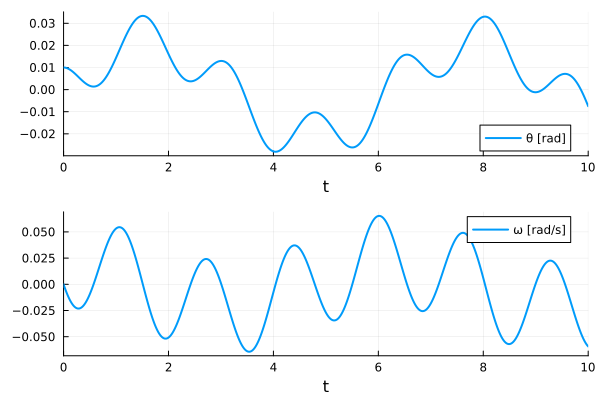

In [ ]:
l = 1.0                             # length [m]
m = 1.0                             # mass [kg]
g = 9.81                            # gravitational acceleration [m/s²]

function pendulum!(du, u, p, t)
    du[1] = u[2]                                                        # θ'(t) = ω(t)
    du[2] = -3p[1] / (2l) * sin(u[1]) + 3 / (m * l^2) * p[2](t)         # ω'(t) = -3g/(2l) sin θ(t) + 3/(ml^2)M(t)
end

θ₀ = 0.01                           # initial angular deflection [rad]
ω₀ = 0.0                            # initial angular velocity [rad/s]
u₀ = [θ₀, ω₀]                       # initial state vector
tspan = (0.0, 10.0)                 # time interval
  
M(t) = 0.1sin(t)                    # external torque [Nm]

prob = ODEProblem(pendulum!, u₀, tspan, (g, M))
sol = solve(prob)

gr()
plot(sol, linewidth = 2, xaxis = "t", label = ["θ [rad]" "ω [rad/s]"], layout = (2, 1))

Note how the external **time-varying** torque `M` is introduced as a **parameter** in the `pendulum!` function. Indeed, as a general principle the parameters can be any type; here we specify `M` as time-varying by representing it by a function, which is expressed by appending the dependence on time `(t)` to the name of the parameter.

## Example 4: Using Other Types for Systems of Equations <a id="using_other_types" />

DifferentialEquations.jl can handle many different dependent variable types
(generally, anything with a linear index should work!). So instead of solving a
vector equation, let's let `u` be a matrix! To do this, we simply need to have `u0`
be a matrix, and define `f` such that it takes in a matrix and outputs a matrix.
We can define a matrix of linear ODEs as follows:


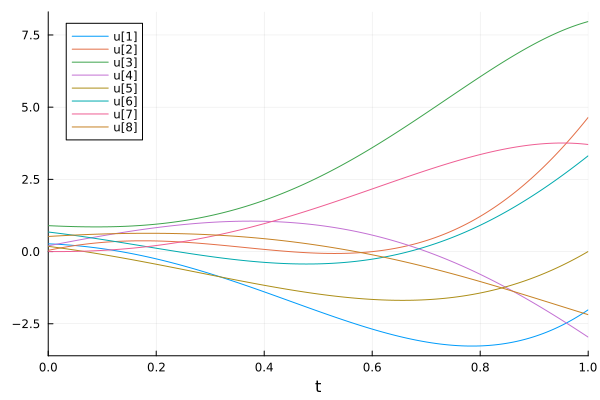

In [13]:
A = [1.0 0 0 -5
     4 -2 4 -3
     -4 0 0 1
     5 -2 2 3]
u0 = rand(4, 2)
tspan = (0.0, 1.0)
f(u, p, t) = A * u
prob = ODEProblem(f, u0, tspan)

sol = solve(prob)
plot(sol)

We can instead use the in-place form by using Julia's in-place matrix multiplication
function `mul!`:

In [14]:
using LinearAlgebra
f(du, u, p, t) = mul!(du, A, u);

Additionally, we can use non-traditional array types as well. For example,
`StaticArrays.jl` offers immutable arrays which are stack-allocated, meaning
that their usage does not require any (slow) heap-allocations that arrays
normally have. This means that they can be used to solve the same problem as
above, with the only change being the type for the initial condition and constants:

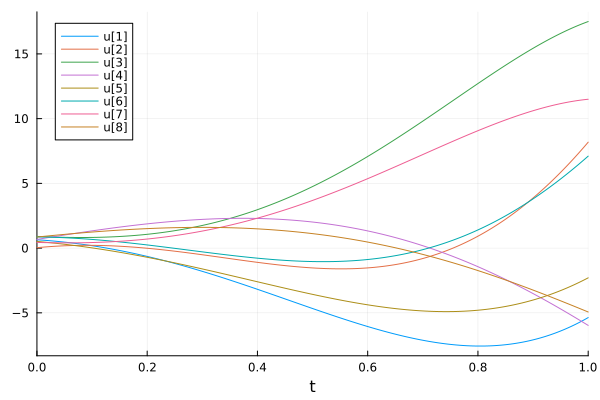

In [17]:
using StaticArrays
A = @SMatrix [1.0 0.0 0.0 -5.0
              4.0 -2.0 4.0 -3.0
              -4.0 0.0 0.0 1.0
              5.0 -2.0 2.0 3.0]
u0 = @SMatrix rand(4, 2)
tspan = (0.0, 1.0)
f2(u, p, t) = A * u
prob = ODEProblem(f2, u0, tspan)
sol = solve(prob)
plot(sol)

> Note that the analysis tools generalize over to systems of equations as well.

In [18]:
sol[4]

4×2 SMatrix{4, 2, Float64, 8} with indices SOneTo(4)×SOneTo(2):
 -0.249039  -0.376805
  0.126456   0.445839
  0.9165     0.54784
  1.66356    1.41115

still returns the solution at the fourth timestep. It also indexes into the array
as well. The last value is the timestep, and the beginning values are for the component.
This means

In [19]:
sol[5, 3]

0.13305345853215514

is the value of the 5th component (by linear indexing) at the 3rd timepoint, or

In [20]:
sol[2, 1, :]

11-element Vector{Float64}:
  0.03208695686686058
  0.11260850366063724
  0.21303194518877452
  0.1264557031605694
 -0.23466552831807813
 -0.8738678767900184
 -1.5087688563709938
 -1.3320187987688177
  0.8464300216607226
  6.272877305612961
  8.182039529546307

is the timeseries for the component, which is the 2nd row and 1st column.

### Exercise 1 - Heat Loss Problem

[[source](#https://math.libretexts.org/Workbench/Numerical_Methods_with_Applications_(Kaw)/8%3A_Ordinary_Differential_Equations/8.00%3A_Physical_Problems_for_Ordinary_Differential_Equations)]

In [1]:
function f(u, p, t) 
    m, cₚ, A, ε, σ, θₐ, h = p
    du = 1 / (m*cₚ) * ( - A*ε*σ*(u^4-θₐ) - h*A*(u-θₐ) )
end

f (generic function with 1 method)

In [4]:
R = 2e-2
ρ = 7800
cₚ = 420
ε = 0.85
σ = 5.67e-8
θ₀ = 1200.0
θₐ = 300
h = 350

A = 4*pi*R^2
m = ρ*((4/3)*pi*R^3)

p = m, cₚ, A, ε, σ, θₐ, h

using DifferentialEquations
u0 = θ₀
tspan = (0.0, 10.0)
prob = ODEProblem(f, u0, tspan, p)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: 1200.0

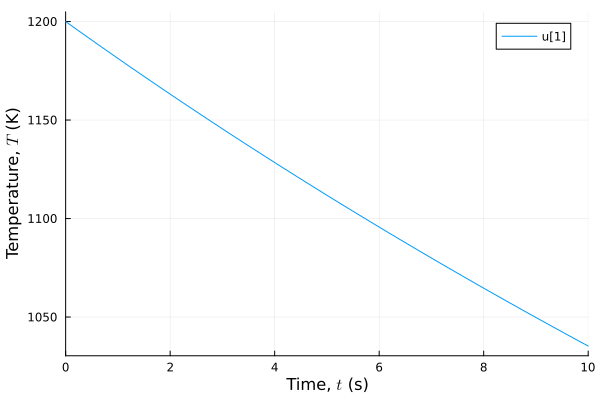

In [5]:
sol = solve(prob, saveat = 0.1);                             # Uses 5th order Tsitouras algorithm

using Plots
using LaTeXStrings
plot(sol, xlabel=L"Time, $t$ (s)", ylabel=L"Temperature, $T$ (K)")

### Exercise 2 - Some ODE

Let's say we have

$$ u'' - 6 u' + 8 u = 3 e^-{5t}, $$

$u_0 = 1$ and $u_0' = 42$.

The analytic solution is:

In [61]:
A = [1 1; 2 4]
b = [20/21; 887/21]
C₁, C₂ = A\b

uₐ(t) = @. C₁ * exp(2*t) + C₂ * exp(4*t) + 1/21 * exp(-5*t)

uₐ (generic function with 1 method)

For the numeric solution, we convert the $2^\text{nd}$ order ODE into a system of first order ODEs:

Call $u_1 = u$ and $u_2 = u'$. 

$$ u_1' = u_2 $$
$$ u_2'' = 3 e^{-5 t} + 6 u_2 - 8 u_1.$$

In [65]:
using DifferentialEquations
function ODE_fun!(du, u, p, t)
    du[1] = u[2]
    du[2] = 3*exp(-5*t) + 6*u[2] - 8*u[1]
end

u0 = [1.0, 42.]
tspan = (0.0, tf)
prob = ODEProblem(ODE_fun!, u0, tspan)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)                # Uses 5th order Tsitouras algorithm

using Plots
tf = 10.
t_vec = range(0., tf, 100)
P = plot(t_vec, uₐ(t_vec), xlabel=L"Time, $t$ (s)", ylabel=L"$u$", label="Analytic")
plot!(P, sol, title = "Solution to the linear ODE", label = "Numerical", idxs=(1), ls=:dash)      